# Intro to Distributional Reinforcement Learning

## The Limitation of Expectations

Traditional reinforcement learning algorithms operate on expected values, representing each state-action pair with a single number. This simplification, while computationally convenient, discards crucial information about the underlying reward structure. The traditional Q-learning framework treats different reward distributions as identical if they share the same expected value, leading to:

1. Risk-Insensitive Decision Making
2. Poor Performance in Multimodal Reward Distributions
3. Slower Learning in Environments with Reward Variability

## Beyond Expectations: A Distributional Perspective

Rather than reducing a state-action pair to a single expected value, a distributional approach maintains the full spectrum of possible outcomes. The categorical DQN (C51) algorithm discretizes this distribution into a fixed set of atoms, enabling the network to learn uncertainty explicitly.

This distributional representation captures critical information about:
- Reward Variance
- Risk Profiles
- Multimodality in Returns

The following implementation demonstrates how C51 learns and utilizes these complete return distributions, providing a more robust framework for decision-making under uncertainty. The original paper can be found [here](https://arxiv.org/abs/1707.06887).


# Simulation Environment

In [8]:
# Game of Pong Simulation environment
import gymnasium as gym
import gymnasium.utils.seeding as seeding
from gymnasium.wrappers import AtariPreprocessing
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
BUFFER_SIZE = int(1e5)    # replay buffer size
BATCH_SIZE = 64           # minibatch size
GAMMA = 0.99              # discount factor
TAU = 1e-3               # for soft update of target parameters
LR = 5e-4                # learning rate
UPDATE_EVERY = 4         # how often to update the network

# C51 specific parameters
N_ATOMS = 51             # number of atoms for distribution
V_MIN = -10             # minimum value of distribution support
V_MAX = 10              # maximum value of distribution support
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)  # support interval

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the Pong environment
DefaultRandomSeed = 10
env = gym.make("ALE/Pong-v5", frameskip=1)
env.np_random, _ = seeding.np_random(DefaultRandomSeed)
env.reset(seed=DefaultRandomSeed)
env = AtariPreprocessing(env)  # Frame skipping, Grayscale, Resize (To 84*84)

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/DRL101/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 932445052
Game console created:
  ROM file:  /opt/anaconda3/envs/DRL101/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1705377069


# Mathematical Framework: From DQN to Distributional RL

## DQN Foundations Review
The Bellman equation forms the basis of DQN:

$$
Q(s,a) = \mathbb{E}[R(s,a) + \gamma \max_{a'} Q(s',a')]
$$

The optimization objective minimizes:

$$
\mathcal{L}(\theta) = \mathbb{E}[(r + \gamma \max_{a'} Q(s',a';\theta^-) - Q(s,a;\theta))^2]
$$

where:
- $\theta$ represents the online network parameters
- $\theta^-$ represents the target network parameters

## The Distributional Extension

Rather than reducing state-action pairs to single expected values, C51 maintains the full distribution of possible returns through the distributional Bellman equation:

$Z(s,a) \stackrel{D}{=} R(s,a) + \gamma Z(s',\arg\max_{a'}\mathbb{E}[Z(s',a')])$

Where:
- Z(s,a) represents the random return from state s and action a
- ≐ denotes equality in distribution
- R(s,a) is the immediate reward distribution
- γ is the discount factor
- Z(s',a') is the return distribution for the next state-action pair

In other words :

$$ Q(s,a) = \mathbb{E}[Z(s,a)]$$


## Categorical Parameterization

To make this mathematically tractable, C51 parameterizes the return distribution using N discrete atoms:

$z_i = V_{MIN} + i\Delta z$ for $i \in \{0,...,N-1\}$
$\Delta z = \frac{V_{MAX} - V_{MIN}}{N-1}$

Therefore the output of the neural network is a $N_A * N_N $ matrix where each row represents the return value of $N_N $ atoms for an action between $N_A$ actions. 

<!-- The probability mass function is defined through a neural network:

$P_\theta(s,a) = \{\mathbf{p}_i(s,a) = \frac{e^{\theta_i(s,a)}}{\sum_j e^{\theta_j(s,a)}}\}_{i=0}^{N-1}$ -->

<!-- The optimization objective becomes:

$\mathcal{L}(\theta) = D_{KL}(\Phi \hat{Z}_{\theta^-} || Z_\theta)$

where:
- $\Phi$ is the categorical projection operator
- $D_{KL}$ is the Kullback-Leibler divergence
- $\hat{Z}_{\theta^-}$ is the target network distribution
- $Z_\theta$ is the online network distribution -->

## Loss Function
The optimization objective is to minimize the divergence between the target and output of the online network. The Kullback-Leibler divergence is used to measure the difference between two distributions. In the case of C51, the target distribtion is :

$$
\hat{Z}_{\theta^-} = R(s,a) + \gamma Z(s',a*)
$$
where 
$$
a* = \arg\max_{a'}\mathbb{E}[Z(s',a')]
$$

However, this target distribution is not aligned with the atoms of the online network. Therefore, it is necessary to project each atom of the target distribution to the closest atom of the online network. This mismatch is show graphically in the following cells.



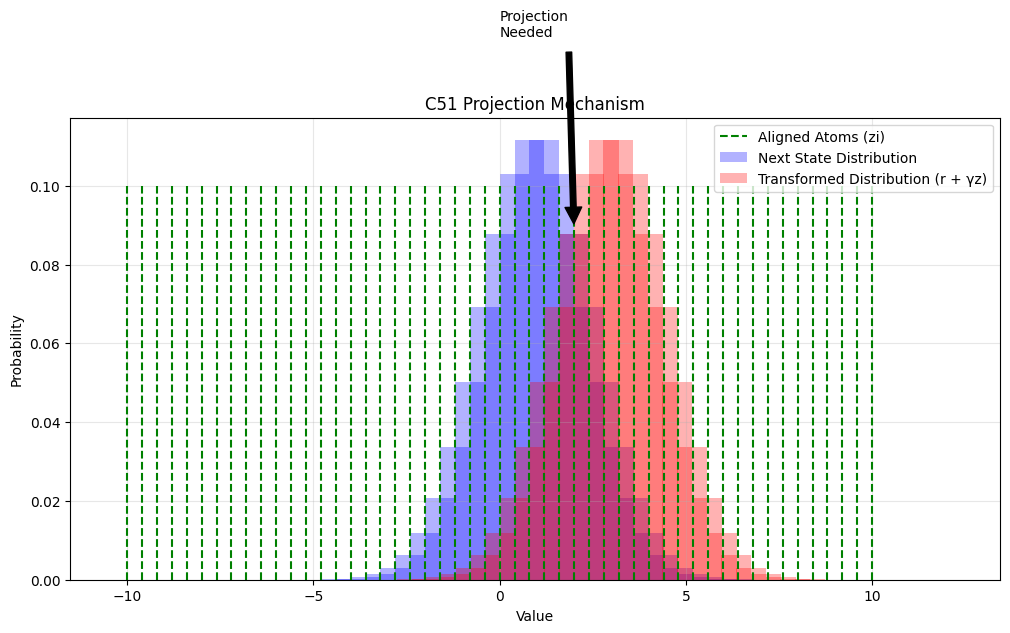

In [24]:
def visualize_projection_mechanism():
    # Setup parameters
    V_MIN, V_MAX = -10, 10
    N_ATOMS = 51
    GAMMA = 0.99
    REWARD = 2.0

    # Create support points (aligned atoms)
    support = np.linspace(V_MIN, V_MAX, N_ATOMS)

    # Create next-state distribution (example)
    next_distr = F.softmax(torch.tensor([-((x - 1)**2)/4 for x in support]), dim=0).numpy()

    # Calculate transformed atoms (Tz = r + γz)
    transformed_support = REWARD + GAMMA * support

    plt.figure(figsize=(12, 6))

    # Plot original support points and distribution
    plt.bar(support, next_distr, alpha=0.3, label='Next State Distribution', color='blue')

    # Plot transformed support points
    plt.bar(transformed_support, next_distr, alpha=0.3, label='Transformed Distribution (r + γz)', color='red')

    # Mark aligned atoms
    plt.vlines(support, 0, 0.1, colors='green', linestyles='dashed', label='Aligned Atoms (zi)')

    # Annotate key components
    plt.annotate('Projection\nNeeded', xy=(transformed_support[25], next_distr[25]),
                xytext=(transformed_support[25]-2, next_distr[25]+0.05),
                arrowprops=dict(facecolor='black', shrink=0.05))

    plt.title('C51 Projection Mechanism')
    plt.xlabel('Value')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_projection_mechanism()

## Categorical Projection

**Each misaligned atom** shoub be projected onto the **nearest aligned atoms** $z_0, z_1, \ldots, z_n$. Suppose $z_j$ is a misaligned atom. We find the indices of the closest aligned atoms to the left ($\ell$) and right ($u$) as follows:

$$
\ell = \left\lfloor \frac{z_j - z_0}{\Delta z} \right\rfloor, 
\quad
u = \left\lceil \frac{z_j - z_0}{\Delta z} \right\rceil,
$$

where $\Delta z$ is the distance between any two adjacent atoms. Next, let the probability associated with $z_j$ be $q_j$. We then update the probabilities of the aligned atoms at positions $\ell$ and $u$:

$$
m_\ell = q_j 
\Bigl(u - \frac{z_j - z_0}{\Delta z}\Bigr), 
\quad
m_r = q_j 
\Bigl(\frac{z_j - z_0}{\Delta z} - \ell\Bigr).
$$

Here, $m_\ell$ and $m_r$ are the probability masses assigned to the respective aligned atoms. The graphical representation of this projection is shown in the following cell.


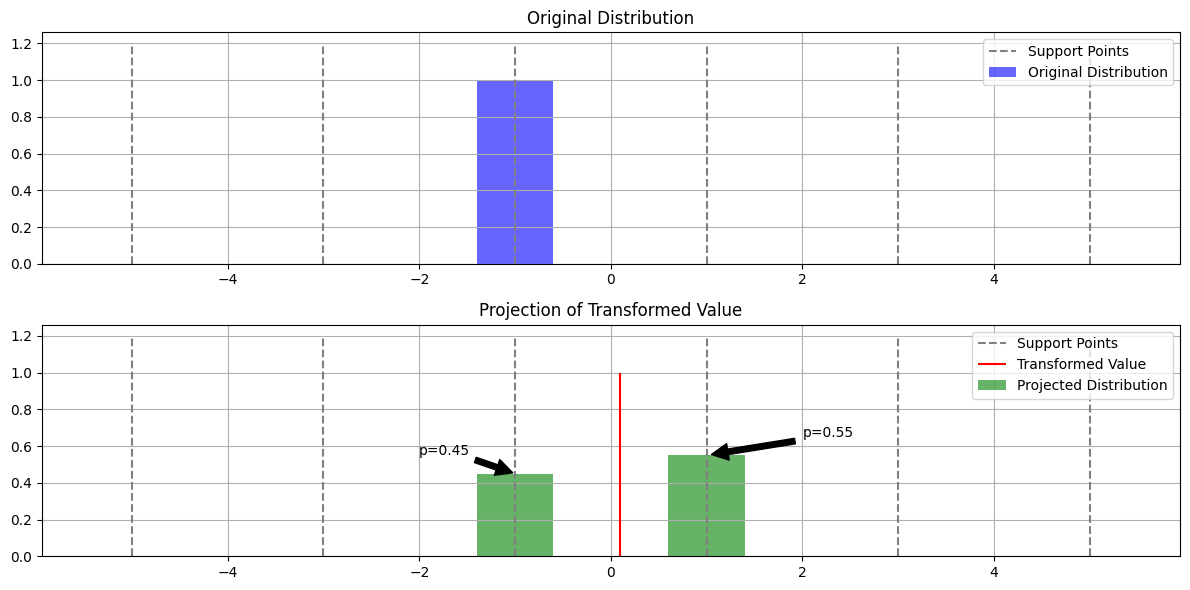

In [26]:

def show_projection_example():
    # Simple example with fewer atoms for clarity
    V_MIN, V_MAX = -5, 5
    N_ATOMS = 6
    support = np.linspace(V_MIN, V_MAX, N_ATOMS)
    GAMMA = 0.9
    REWARD = 1

    # Create a simple distribution (probability mass on a single atom)
    orig_dist = np.zeros(N_ATOMS)
    orig_dist[2] = 1.0  # Put all probability mass on the middle atom
    
    # Calculate transformed value
    orig_value = support[2]
    transformed_value = REWARD + GAMMA * orig_value
    
    plt.figure(figsize=(12, 6))
    
    # Plot original support and distribution
    plt.subplot(2, 1, 1)
    plt.bar(support, orig_dist, alpha=0.6, color='blue', label='Original Distribution')
    plt.vlines(support, 0, 1.2, colors='gray', linestyles='--', label='Support Points')
    plt.title('Original Distribution')
    plt.legend()
    plt.grid(True)
    
    # Plot transformed value and projection
    plt.subplot(2, 1, 2)
    plt.vlines(support, 0, 1.2, colors='gray', linestyles='--', label='Support Points')
    plt.vlines(transformed_value, 0, 1.0, colors='red', label='Transformed Value')
    
    # Find adjacent support points
    idx_left = np.searchsorted(support, transformed_value) - 1
    idx_right = idx_left + 1
    
    # Calculate probability distribution
    left_prob = (support[idx_right] - transformed_value) / (support[idx_right] - support[idx_left])
    right_prob = 1 - left_prob
    
    # Plot projected probabilities
    projected_dist = np.zeros(N_ATOMS)
    projected_dist[idx_left] = left_prob
    projected_dist[idx_right] = right_prob
    plt.bar(support, projected_dist, alpha=0.6, color='green', label='Projected Distribution')
    
    # Add annotations
    plt.annotate(f'p={left_prob:.2f}', xy=(support[idx_left], left_prob), 
                xytext=(support[idx_left]-1, left_prob+0.1), 
                arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate(f'p={right_prob:.2f}', xy=(support[idx_right], right_prob), 
                xytext=(support[idx_right]+1, right_prob+0.1), 
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.title('Projection of Transformed Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

show_projection_example()